In [5]:
using DelimitedFiles, HDF5, FileIO
using Plots, Rsvg, LaTeXStrings
using Chemfiles, JUMD
using LinearAlgebra, Statistics
home = "/home/pbarletta/labo/19/opc_lbp/run"
rtdos = "/home/pbarletta/labo/19/opc_lbp/rtdos_log"

"/home/pbarletta/labo/19/opc_lbp/rtdos_log"

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [6]:
pdb = "1ifb"
# Leo modos
modes_1ifb, evals_1ifb = JUMD.readPtrajModes(joinpath(home, pdb,  "pca", string("modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_1ifb))
aa = convert(Int64, aa3 / 3)

# Leo volumen de la traj
trj_vol = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);

# Leo volúmenes originales
vol_avg_1ifb = convert(Float64, readdlm(joinpath(home, pdb,  "cavidad", string("vol_avg_", pdb)))[3])

713.942

## Volumen de la trayectoria

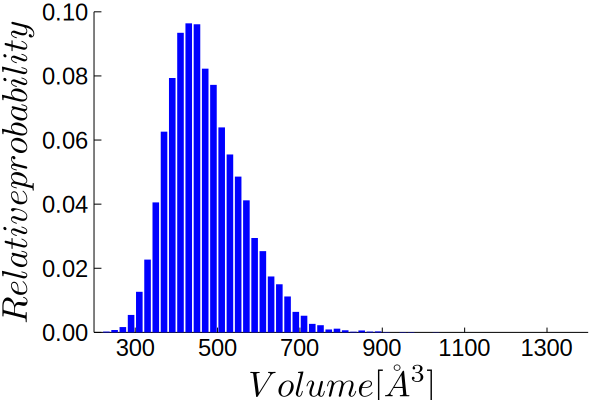

In [14]:
st = 20
bin_vol = collect(200:st:1400)
wgh_vol = fill(1.0, length(trj_vol))

# Histograma ponderado
Wbins_vol_1ifb, Whis_vol_1ifb = JUMD.weightedHist(trj_vol, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_1ifb, Whis_vol_1ifb,
    xlims = (200, 1400), ylims = (0, .1),
    xticks = 300:200:1400,
    linecolor = false, fillcolor = Colors.colorant"#0000FF",
    grid = false, legend = false,
    guidefont = font(24, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"),
    yaxis = L"Relative probability", xaxis = L"Volume [\r{A}^{3}]")

In [14]:
savefig(plt_his_vol, joinpath(rtdos, "papel", "8", string("8_vol_", pdb, ".svg")))

In [17]:
[ mean(trj_vol) ; std(trj_vol) ; std(trj_vol) / mean(trj_vol) ]

3-element Array{Float64,1}:
 470.12664715        
  90.40253389750202  
   0.1922940008730412

# PCA projección
#### Obtengo vectores diferencia de la trayectoria. Esto lo hago una sola vez

#### Obtengo las proyecciónes de vectores diferencia sobre los 1eros PCA

In [3]:
dif = h5read(joinpath(rtdos, string("diff_", pdb, ".h5")), "dif")
norm_dif = mapslices(x -> x ./ norm(x), dif, dims = 1)
nframes = size(dif)[2]

prj_1_1ifb = Array{Float64, 1}(undef, nframes)
prj_2_1ifb = Array{Float64, 1}(undef, nframes)
prj_3_1ifb = Array{Float64, 1}(undef, nframes)

for i = 1:nframes
    prj_1_1ifb[i] = dot(norm_dif[:, i], modes_1ifb[:, 1])
    prj_2_1ifb[i] = dot(norm_dif[:, i], modes_1ifb[:, 2])
    prj_3_1ifb[i] = dot(norm_dif[:, i], modes_1ifb[:, 3])
end

# Smooth
smooth_prj_1_1ifb = [ mean(prj_1_1ifb[i:i+9]) for i = 1:10:length(prj_1_1ifb)-9 ]
smooth_prj_2_1ifb = [ mean(prj_2_1ifb[i:i+9]) for i = 1:10:length(prj_2_1ifb)-9 ]
smooth_prj_3_1ifb = [ mean(prj_3_1ifb[i:i+9]) for i = 1:10:length(prj_3_1ifb)-9 ];

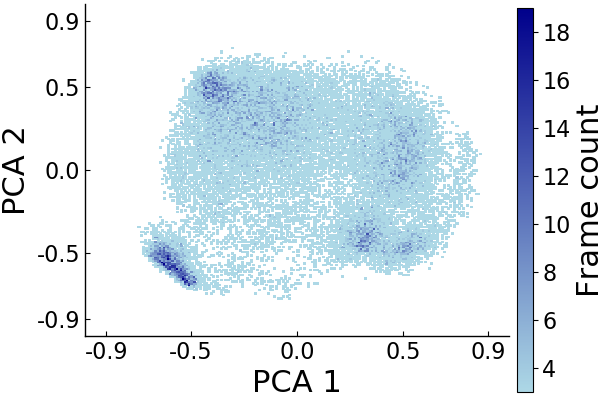

In [5]:
plt_2his = histogram2d(smooth_prj_1_1ifb, smooth_prj_2_1ifb, 
    xlims = (-1, 1), ylims = (-1, 1),
    xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
    yaxis = "PCA 2", xaxis = "PCA 1",
    colorbar_title = "Frame count",
    guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"), clims = (3, 19),
    nbins = 180, seriescolor = :blues, grid = false)

In [8]:
savefig(plt_2his, joinpath(rtdos, "papel", "2", string("SI_PCAHis_", pdb, ".svg")))

In [13]:
using Makie, GeometryTypes

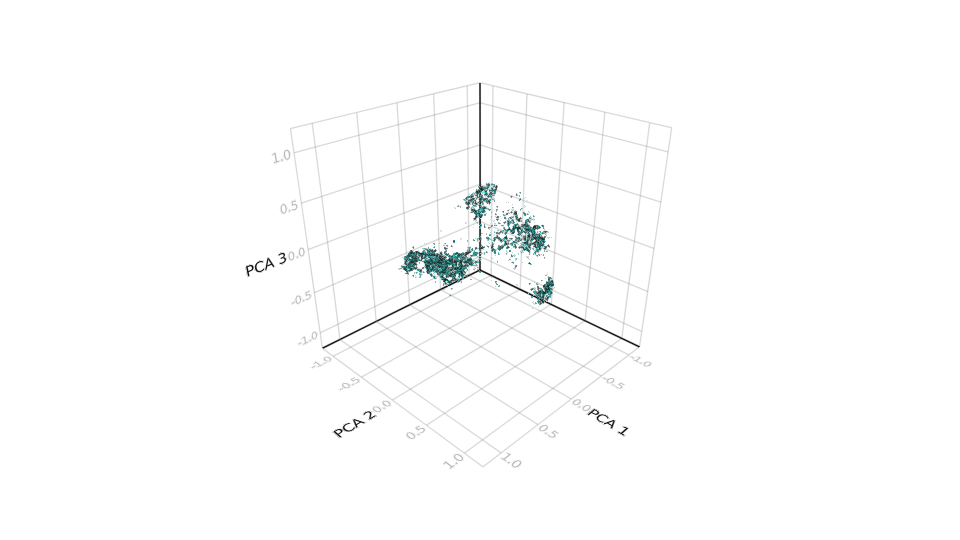

In [14]:
xyz_bins = collect(-1:.025:1)

his_ind, his = JUMD.hisInd3D(smooth_prj_1_1ifb, smooth_prj_2_1ifb, smooth_prj_3_1ifb,
    xyz_bins, xyz_bins, xyz_bins)

cuentas = 2
msk = his .> cuentas
main_his = his[msk]
main_his_ind = his_ind[msk];

sc = Makie.volume(convert(Array{Float64,3}, msk), algorithm = :iso)
sc[Axis][:names, :axisnames] = ("PCA 1", "PCA 2", "PCA 3")

tck_lab = string.(collect(-1.:.5:1.))
sc[Axis][:ticks][:labels] = (tck_lab, tck_lab, tck_lab)

eyepos = Vec3f0(185, 115, 70)
lookat = Vec3f0(1, 1, 1)
update_cam!(sc, eyepos, lookat)

#Makie.save(joinpath(rtdos, string("3D_", pdb, ".png")), sc)

sc

In [18]:
marcos_pnu = Array{Int64, 1}(undef, nframes)
marcos_modos = Array{Array{Int64, 1}}(undef, nframes)

for i = 1:nframes
    tmp = reshape(mapslices(x->dot(x, norm_dif[:, i]), modes_1ifb, dims = 1), aa3)
    marcos_pnu[i] = JUMD.getPnum(tmp)
    marcos_modos[i] = sortperm(abs.(tmp), rev = true)[1:marcos_pnu[i]]
end

# Guardo los pnumbers
fid = h5open(joinpath(rtdos, string("marcos_pnu_", pdb, ".h5")), "w")
write(fid, "pnu", marcos_pnu)
close(fid)

# Guardo los pnumbers modos de c/ frame
fid = h5open(joinpath(rtdos, string("marcos_modos_", pdb, ".h5")), "w")
for i = 1:nframes
    write(fid, string("frame_", i), marcos_modos[i])
end
close(fid)

In [7]:
# Read Pnumbers
marcos_pnu = h5read(joinpath(rtdos, string("marcos_pnu_", pdb, ".h5")), "pnu")

# Read Frecuencia de apariciónd de c/ modo en los subespacios de pnumber modos
marcos_modos = Array{Array{Int64, 1}}(undef, nframes)
fid = h5open(joinpath(rtdos, string("marcos_modos_", pdb, ".h5")), "r")
for i = 1:nframes
    marcos_modos[i] = read(fid, string("frame_", i))
end
close(fid)
flat_marcos_modos = collect(Iterators.flatten(marcos_modos));

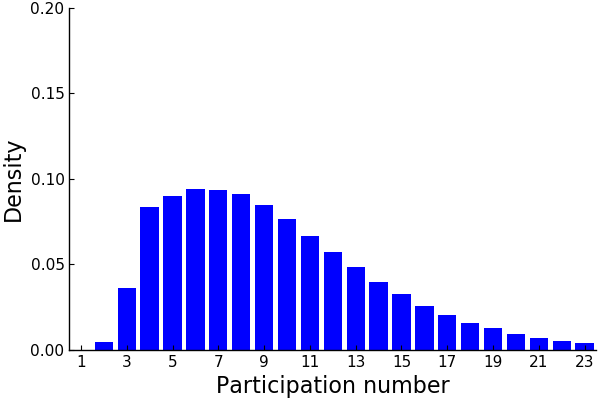

In [20]:
bin_vol = collect(1:1:25)
wgh_vol = fill(1.0, length(marcos_pnu))

# Histograma ponderado
bins_marcos_pnu, his_marcos_pnu = JUMD.weightedHist(marcos_pnu, bin_vol, wgh_vol, true, false);

plt_his_pn = bar(bins_marcos_pnu .- .5 , his_marcos_pnu,
    ylims = (0, .2), xlims = (.5, 23.5),
    xticks = 1:2:23, yticks = 0:.05:.2,
    fillcolor = Colors.colorant"#0000FF", linecolor = false,
    guidefont = font(16, "Arial"), tickfont = font(11, "Arial"),
    yaxis = "Density", xaxis = "Participation number",
    legend = false, grid = false)

In [21]:
savefig(plt_his_pn, joinpath(rtdos, "papel",  "2", string("2_HisPn_", pdb, ".svg")))

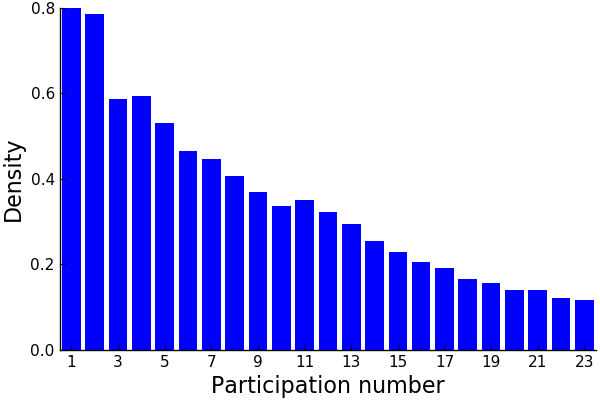

In [22]:
bin_mod = collect(1:1:25)
wgh_mod = fill(1 / nframes, length(flat_marcos_modos))

# Histograma ponderado
bins_marcos_mod, his_marcos_mod = JUMD.weightedHist(flat_marcos_modos,
    bin_mod, wgh_mod, false, false);

plt_freq_pn = bar(bins_marcos_mod .- .5, his_marcos_mod,
    ylims = (0, .8), xlims = (.5, 23.5),
    xticks = 1:2:23, yticks = 0:.2:.8,    
    fillcolor = Colors.colorant"#0000FF", linecolor = false,
    guidefont = font(16, "Arial"), tickfont = font(11, "Arial"),
    yaxis = "Density", xaxis = "Participation number",
    legend = false, grid = false)

In [23]:
savefig(plt_freq_pn, joinpath(rtdos, "papel",  "2", string("2_ModPn_", pdb, ".svg")))

## Guardo el gradiente

In [ ]:
car_vgv_1ifb = (modes_1ifb * vgv_1ifb) .* -1.
writedlm("/home/pbarletta/labo/18/lbp/rtdos_log/porcupines/1ifb/car_vgv_1ifb",
    car_vgv_1ifb)

## Proyecciones de PCA

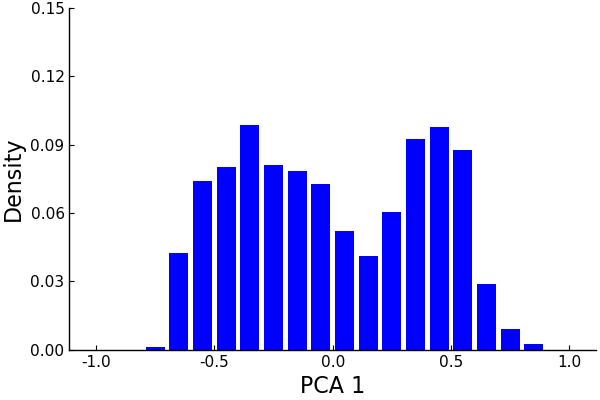

In [4]:
bins = collect(-1.:.1:1.)
wghs = fill(1.0, length(smooth_prj_1_1ifb))

# Histograma ponderado
Wbins_prj_1ifb, Whis_prj_1ifb = JUMD.weightedHist(smooth_prj_1_1ifb, bins, wghs, true, false);

plt_his_prj_1 = bar(Wbins_prj_1ifb, Whis_prj_1ifb,
    ylims = (0, .15),
    linecolor = false, fillcolor = Colors.colorant"#0000FF",
    grid = false, legend = false,
    guidefont = font(16, "Arial"), tickfont = font(11, "Arial"),
    yaxis = "Density", xaxis = "PCA 1")

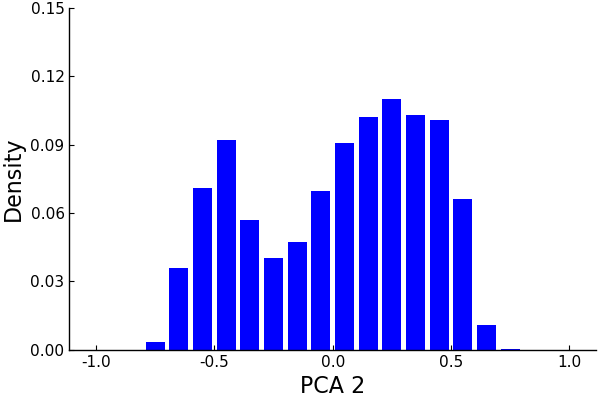

In [5]:
bins = collect(-1.:.1:1.)
wghs = fill(1.0, length(smooth_prj_2_1ifb))

# Histograma ponderado
Wbins_prj_1ifb, Whis_prj_1ifb = JUMD.weightedHist(smooth_prj_2_1ifb, bins, wghs, true, false);

plt_his_prj_2 = bar(Wbins_prj_1ifb, Whis_prj_1ifb,
    ylims = (0, .15),
    linecolor = false, fillcolor = Colors.colorant"#0000FF",
    grid = false, legend = false,
    guidefont = font(16, "Arial"), tickfont = font(11, "Arial"),
    yaxis = "Density", xaxis = "PCA 2")

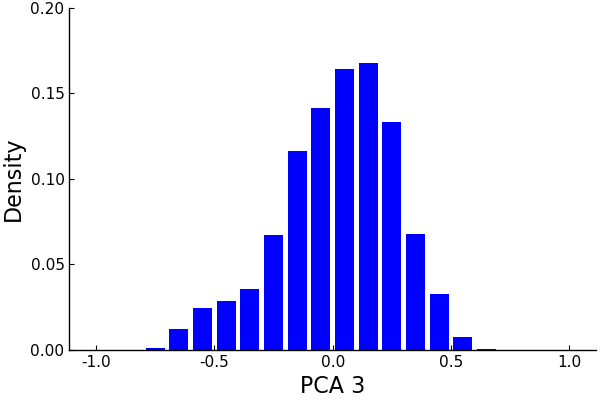

In [6]:
bins = collect(-1.:.1:1.)
wghs = fill(1.0, length(smooth_prj_3_1ifb))

# Histograma ponderado
Wbins_prj_1ifb, Whis_prj_1ifb = JUMD.weightedHist(smooth_prj_3_1ifb, bins, wghs, true, false);

plt_his_prj_3 = bar(Wbins_prj_1ifb, Whis_prj_1ifb,
    ylims = (0, .2),
    linecolor = false, fillcolor = Colors.colorant"#0000FF",
    grid = false, legend = false,
    guidefont = font(16, "Arial"), tickfont = font(11, "Arial"),
    yaxis = "Density", xaxis = "PCA 3")

In [7]:
savefig(plt_his_prj_1, joinpath(rtdos, "papel", "2", string("SI_PCA1His_", pdb, ".svg")))
savefig(plt_his_prj_2, joinpath(rtdos, "papel", "2", string("SI_PCA2His_", pdb, ".svg")))
savefig(plt_his_prj_3, joinpath(rtdos, "papel", "2", string("SI_PCA3His_", pdb, ".svg")))